In [1]:
%run ../src/utils/helpers.py

import boto3
import requests
import random
import numpy as np
import tempfile
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
s3 = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)
files = [file.key for file in bucket.objects.filter()]
len(files)

134831

In [30]:
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record
    
def label_imgs(n=4):
    record = get_record()
    inp = 1
    while inp != 'q':
        # Clean slate
        clear_output()
#         for k, v in record.items():
#             print(k)
        scores = sum(v['score'] for k, v in record.items())
        print(f"{scores} great photos out of {len(record.keys())} photos scored")
        unchecked = reduce(lambda x, y: x + 1 if y['score'] == 0 and y['matches'] == 1 else x, record.values(), 0)
        print(f"{unchecked} unchecked images to go")
        # Get list of n never-before-seen images
        n_files = []
        while len(n_files) < n:
            f = random.choice(files)
            if record.get(f, {'score': None})['score'] == 0 and record.get(f, {'matches': 0})['matches'] < 2:
                n_files.append(f)
#             if f not in record:
#                 n_files.append(f)
        
        print("\nDisplaying:")
        print(n_files)
        fig = plt.figure(figsize=(35,14))
        for i, file in enumerate(n_files):
            obj = bucket.Object(file)
            tmp = tempfile.NamedTemporaryFile()
            with open(tmp.name, 'wb') as f:
                obj.download_fileobj(f)
                img=mpimg.imread(tmp.name)
            ax = fig.add_subplot(n, 1, i + 1) 
            ax.imshow(img)
            ax.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
        # Get scores
        inp = input()
        for i, image in enumerate(n_files):
            print(image, record[image])
            record[image]['score'] = record[image].get('score', 0) + (str(i + 1) in inp)
            record[image]['matches'] = record[image].get('matches', 0) + 1
        save_to(record, record_path)
        
    save_to(record, '../data/raw/record_backup.pkl')
    return record

In [29]:
record = label_imgs(4)

1531 great photos out of 3216 photos scored
0 unchecked images to go


KeyboardInterrupt: 


Displaying images scored 0:
['2018/08/16/2018_0816_055000/thumbnail.jpg', '2017/10/19/2017_1019_160000/thumbnail.jpg', '2018/10/07/2018_1007_180000/thumbnail.jpg', '2018/07/08/2018_0708_164000/thumbnail.jpg', '2019/03/07/2019_0307_122000/thumbnail.jpg', '2017/10/03/2017_1003_085000/thumbnail.jpg', '2017/09/15/2017_0915_123000/thumbnail.jpg', '2019/05/26/2019_0526_161000/thumbnail.jpg']


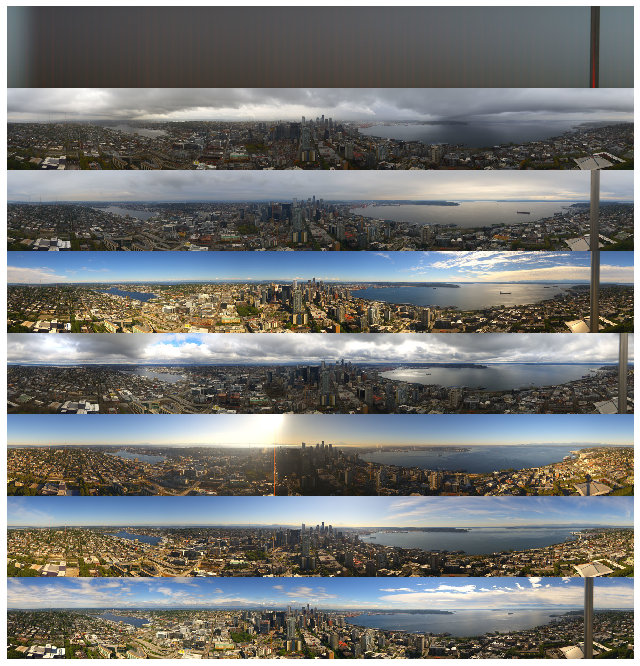

In [99]:
def review_scores(n, score):
    record = get_record()
    l = list(record.keys())

    # Get list of n never-before-seen images
    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return
review_scores(n, 0)

In [93]:
scores['2018/07/10/2018_0710_203000/thumbnail.jpg']

{'score': 0, 'matches': 1}

In [98]:
record['2019/05/23/2019_0523_191000/thumbnail.jpg']['score'] = 1

In [100]:
record_path = '../data/raw/record.pkl'
save_to(record, record_path)
save_to(record, '../data/raw/record_backup.pkl')

Saved file to ../data/raw/record.pkl
Saved file to ../data/raw/record_backup.pkl


# Helpers

In [6]:
from functools import reduce

In [7]:
scores = sum(v['score'] for k, v in record.items())
print(f"{scores} great photos out of {len(record.keys())} photos scored")

1267 great photos out of 3216 photos scored


In [12]:
reduce(lambda x, y: x + 1 if y['score'] == 0 and y['matches'] == 1 else x, record.values(), 0)

906

In [ ]:
import pandas as pd

In [33]:
df = pd.DataFrame.from_dict(record, orient='index')
df[(df['score']==0) & (df['matches']==1)].shape

(0, 2)

In [32]:
record = get_record()